In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 6.59 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.76 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 620 µs


### Database ERD

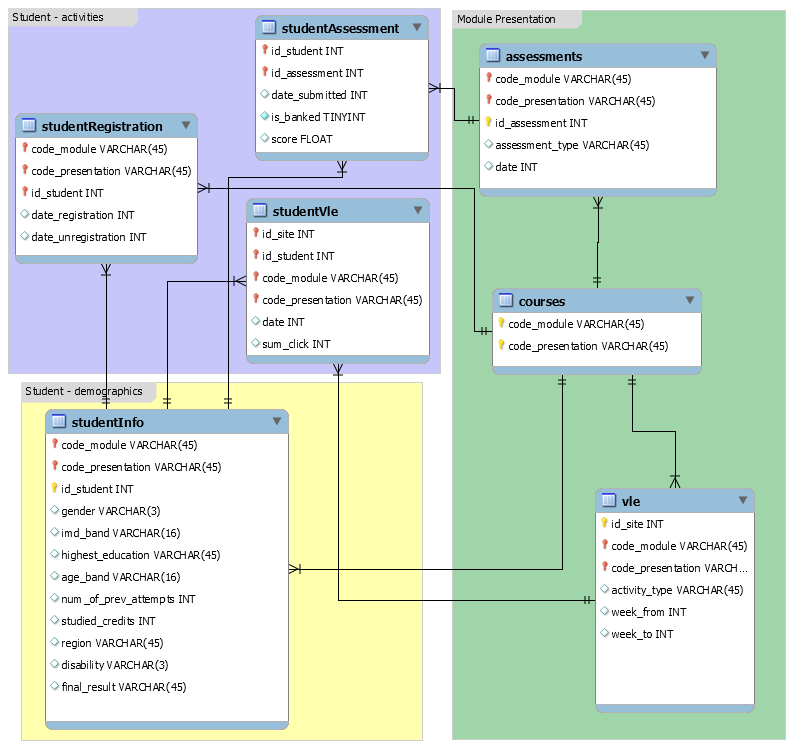

time: 5.59 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.51 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 4.51 ms


## Half Term Data

In [8]:
# database_name = 'outcomes.db'
# db_new = db.Database(database_name)

time: 593 µs


In [9]:
df = db.data_prep(120)

time: 4.85 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24770 entries, 0 to 24769
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                22608 non-null  float64
 1   row_id                24770 non-null  object 
 2   score                 22591 non-null  object 
 3   gender                22608 non-null  object 
 4   region                22608 non-null  object 
 5   highest_education     22608 non-null  object 
 6   imd_band              21686 non-null  object 
 7   age_band              22608 non-null  object 
 8   num_of_prev_attempts  22608 non-null  object 
 9   studied_credits       22608 non-null  float64
 10  disability            22608 non-null  object 
 11  final_result          22608 non-null  object 
 12  date_sub              22608 non-null  float64
 13  course_length         22608 non-null  float64
 14  weighted_ave          22606 non-null  float64
 15  mean_score         

In [11]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration']

time: 846 µs


In [12]:
df = db.pipe_cleaner_wa(df, drops)

time: 74.9 ms


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20229 entries, 1 to 24769
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                20229 non-null  float64 
 1   gender                20229 non-null  object  
 2   region                20229 non-null  object  
 3   highest_education     20229 non-null  object  
 4   imd_band              20229 non-null  object  
 5   age_band              20229 non-null  object  
 6   num_of_prev_attempts  20229 non-null  object  
 7   disability            20229 non-null  object  
 8   weighted_ave          20229 non-null  float64 
 9   mean_score            20229 non-null  float64 
 10  median_score          20229 non-null  float64 
 11  sum_activity          20229 non-null  float64 
 12  course_load           20229 non-null  category
dtypes: category(1), float64(5), object(7)
memory usage: 2.0+ MB
time: 16.1 ms


In [14]:
df.describe()

,target,weighted_ave,mean_score,median_score,sum_activity
count,20229.000000,20229.000000,20229.000000,20229.000000,20229.000000
mean,0.328785,111.560564,75.244944,75.586065,307.703890
std,0.469783,65.170761,14.849566,14.732712,365.193332
min,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,67.440000,67.666667,68.000000,78.000000
50%,0.000000,119.400000,78.333333,78.000000,187.000000
75%,1.000000,158.000000,85.800000,86.000000,399.000000
max,1.000000,298.600000,100.000000,100.000000,5806.000000


time: 48.6 ms


In [15]:
df.target.value_counts(normalize=True)

0.0    0.671215
1.0    0.328785
Name: target, dtype: float64

time: 4.35 ms


## Creating Holdout Data

In [16]:
# splitting data & target
X, y = f.X_y(df)

time: 2.8 ms


In [17]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 11.8 ms


## Creating Training Data

In [18]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.75 ms


## Baseline Model: Dummy Classifier

In [19]:
dummy = DummyClassifier(strategy='most_frequent')

time: 1.04 ms


In [20]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 847 µs


### Fitting Model

In [21]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 46.9 ms


### Saving Model

In [22]:
# f.pickle_model(baseline, 'baseline')

time: 624 µs


### Cross Val Scores

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6712075938121632
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 201 ms


### Test Data Confusion Matrix

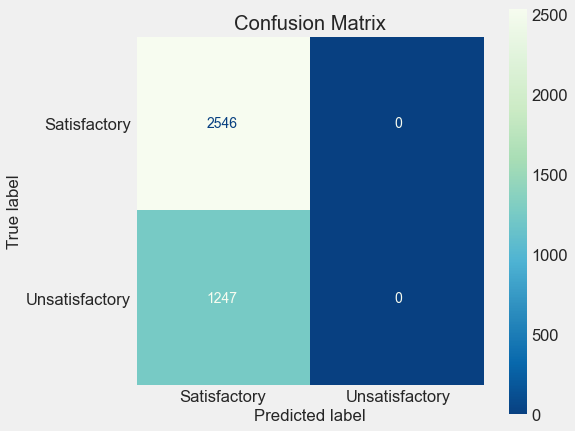

,Accuracy,F1,Recall,Precision
0,0.671236,0.0,0.0,0.0


time: 321 ms


In [24]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [25]:
mnb = MultinomialNB()

time: 691 µs


In [26]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 834 µs


### Fitting Model

In [27]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>)])),
                ('multinomialnb', MultinomialNB())])

time: 44.6 ms


### Saving Model

In [28]:
# f.pickle_model(fsm, 'fsm')

time: 669 µs


### Cross Val Scores

In [29]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6764804650534
 fsm has an average F1 of 0.26043461466422013
 fsm has an average Recall of 0.1737482418625904
 fsm has an average Precision of 0.5229308107458176


[0.6764804650534, 0.26043461466422013, 0.1737482418625904, 0.5229308107458176]

time: 226 ms


### Test Data Confusion Matrix

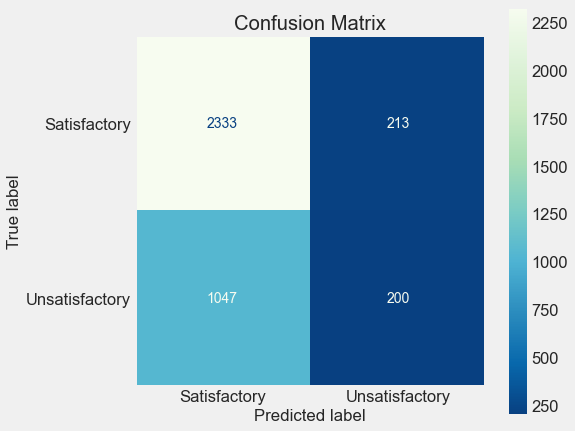

,Accuracy,F1,Recall,Precision
0,0.667809,0.240964,0.160385,0.484262


time: 320 ms


In [30]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# Standard Scaling

## KNeighborsClassifier

In [31]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 821 µs


In [32]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 850 µs


### Fitting Model

In [33]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 54.3 ms


In [34]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 614 µs


### Cross Val Scores

In [35]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7253462986925202
knn_ss has an average F1 of 0.5318582980200475
knn_ss has an average Recall of 0.47473422674082383
knn_ss has an average Precision of 0.6048812674498685


[0.7253462986925202,
 0.5318582980200475,
 0.47473422674082383,
 0.6048812674498685]

time: 3.93 s


### Test Data Confusion Matrix

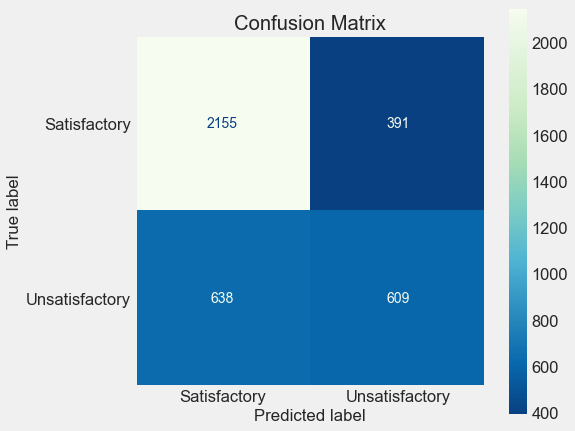

,Accuracy,F1,Recall,Precision
0,0.728711,0.542056,0.488372,0.609


time: 8.08 s


In [36]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [37]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 824 µs


In [38]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 899 µs


### Fitting Model

In [39]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.09 s


In [40]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 797 µs


### Cross Val Scores

In [41]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7449461364645898
logreg_ss has an average F1 of 0.5398457767938926
logreg_ss has an average Recall of 0.4552262196297381
logreg_ss has an average Precision of 0.6633305543887393


[0.7449461364645898,
 0.5398457767938926,
 0.4552262196297381,
 0.6633305543887393]

time: 4.52 s


### Test Data Confusion Matrix

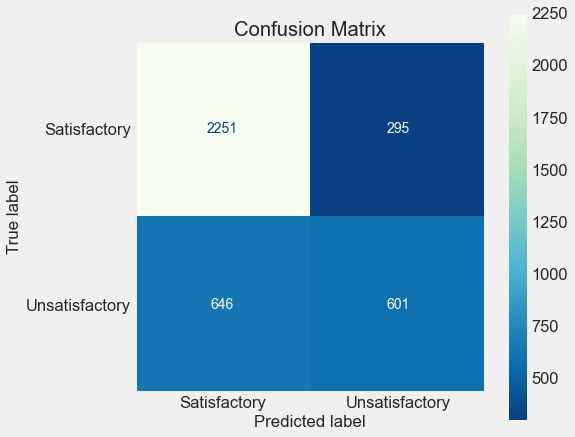

,Accuracy,F1,Recall,Precision
0,0.751911,0.560896,0.481957,0.670759


time: 216 ms


In [42]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [43]:
SVC = SVC()

time: 776 µs


In [44]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 835 µs


### Fitting Model

In [45]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('svc', SVC())])

time: 6.18 s


In [46]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 918 µs


### Cross Val Scores

In [47]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7582170764209428
svc_ss has an average F1 of 0.5553142499453999
svc_ss has an average Recall of 0.45923227404810696
svc_ss has an average Precision of 0.7025134340421844


[0.7582170764209428,
 0.5553142499453999,
 0.45923227404810696,
 0.7025134340421844]

time: 25.1 s


### Test Data Confusion Matrix

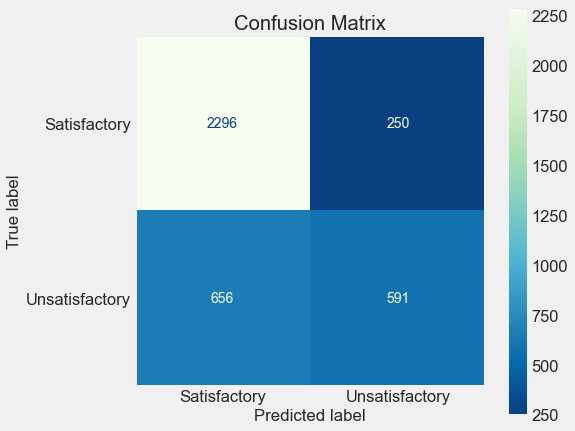

,Accuracy,F1,Recall,Precision
0,0.761139,0.566092,0.473937,0.702735


time: 6.63 s


In [48]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [49]:
LSVC = LinearSVC(random_state=2021)

time: 854 µs


In [50]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 1.05 ms


### Fitting Model

In [51]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 712 ms


In [52]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 632 µs


### Cross Val Scores

In [53]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7438913845381332
lsvc_ss has an average F1 of 0.5299089439224343
lsvc_ss has an average Recall of 0.4391880796498719
lsvc_ss has an average Precision of 0.6679912253494816


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7438913845381332,
 0.5299089439224343,
 0.4391880796498719,
 0.6679912253494816]

time: 2.65 s


### Test Data Confusion Matrix

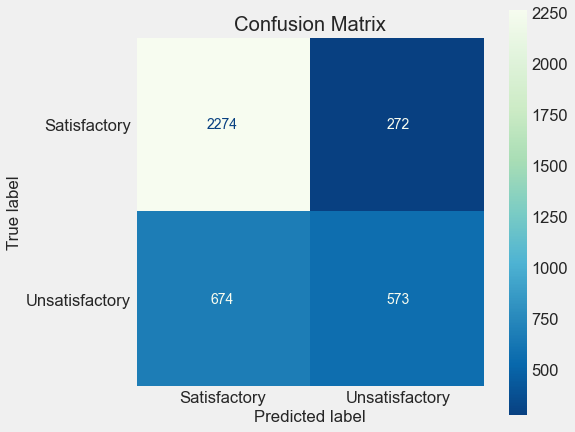

,Accuracy,F1,Recall,Precision
0,0.750593,0.547801,0.459503,0.678107


time: 226 ms


In [54]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [55]:
DT = DecisionTreeClassifier(random_state=2021)

time: 854 µs


In [56]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 1.32 ms


### Fitting Model

In [57]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 526 ms


In [58]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 764 µs


### Cross Val Scores

In [59]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6911565692655324
dt_ss has an average F1 of 0.5364785741136349
dt_ss has an average Recall of 0.5434365249923248
dt_ss has an average Precision of 0.529834447036189


[0.6911565692655324, 0.5364785741136349, 0.5434365249923248, 0.529834447036189]

time: 2.38 s


### Test Data Confusion Matrix

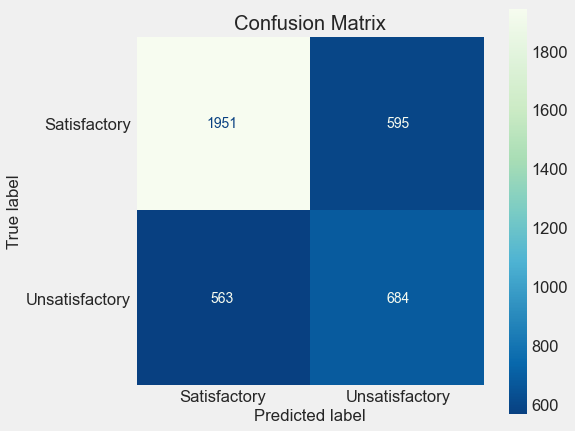

,Accuracy,F1,Recall,Precision
0,0.694701,0.541568,0.548516,0.534793


time: 521 ms


In [60]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [61]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 1.16 ms


In [62]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 821 µs


### Fitting Model

In [63]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.31 s


In [64]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 718 µs


### Cross Val Scores

In [65]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7565473261360783
bclf_ss has an average F1 of 0.5736709581293702
bclf_ss has an average Recall of 0.4982622105766691
bclf_ss has an average Precision of 0.6763207233338944


[0.7565473261360783,
 0.5736709581293702,
 0.4982622105766691,
 0.6763207233338944]

time: 15.1 s


### Test Data Confusion Matrix

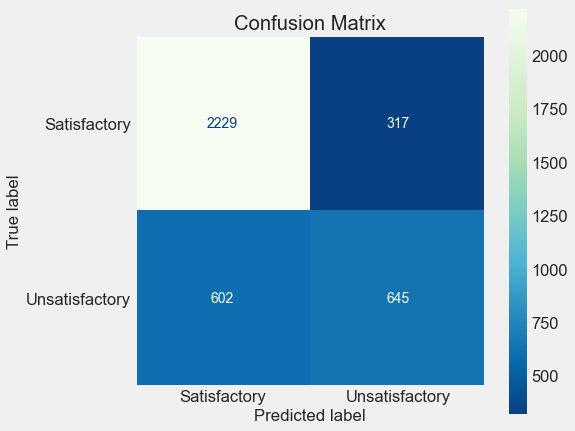

,Accuracy,F1,Recall,Precision
0,0.757712,0.583975,0.517241,0.670478


time: 309 ms


In [66]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [67]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 989 µs


In [68]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 913 µs


### Fitting Model

In [69]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.52 s


In [70]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 672 µs


### Cross Val Scores

In [71]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7662146043762915
rf_ss has an average F1 of 0.5917517899868325
rf_ss has an average Recall of 0.5153641575576705
rf_ss has an average Precision of 0.6947465013958738


[0.7662146043762915,
 0.5917517899868325,
 0.5153641575576705,
 0.6947465013958738]

time: 12.7 s


### Test Data Confusion Matrix

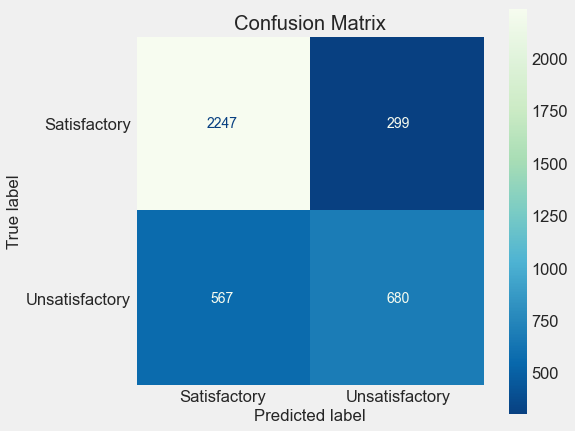

,Accuracy,F1,Recall,Precision
0,0.771685,0.610961,0.545309,0.694586


time: 505 ms


In [72]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [73]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 919 µs


In [74]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 942 µs


### Fitting Model

In [75]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 579 ms


In [76]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 840 µs


### Cross Val Scores

In [77]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6821053709032618
ada_ss has an average F1 of 0.5239955744500021
ada_ss has an average Recall of 0.5324796698628476
ada_ss has an average Precision of 0.5160698324274644


[0.6821053709032618,
 0.5239955744500021,
 0.5324796698628476,
 0.5160698324274644]

time: 2.04 s


### Test Data Confusion Matrix

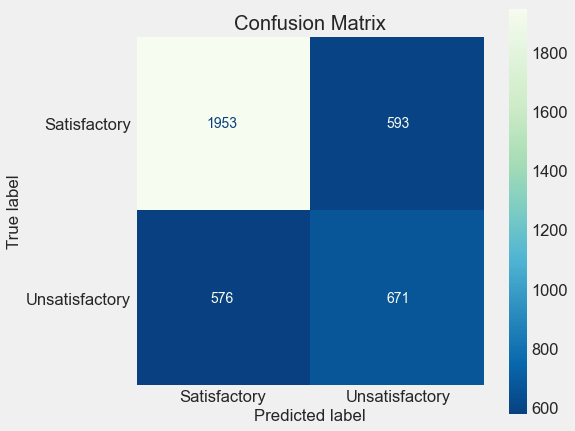

,Accuracy,F1,Recall,Precision
0,0.691801,0.534448,0.538091,0.530854


time: 341 ms


In [78]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [79]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 1.23 ms


In [80]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.92 ms


### Fitting Model

In [81]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.42 s


In [82]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 1.02 ms


### Cross Val Scores

In [83]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.7685875741130574,
 0.6127293358261684,
 0.5567983693052412,
 0.6813048902131328]

time: 6.67 s


### Test Data Confusion Matrix

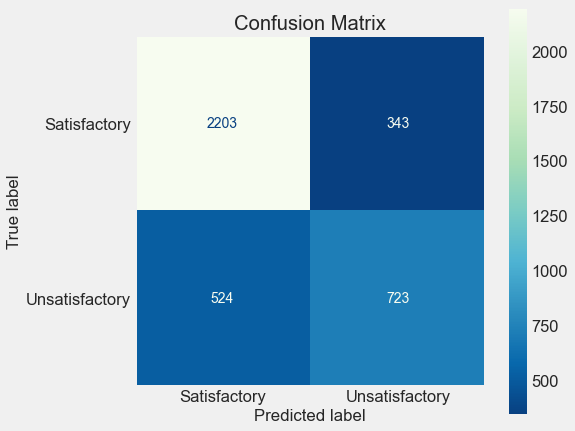

,Accuracy,F1,Recall,Precision
0,0.771421,0.625162,0.579791,0.678236


time: 473 ms


In [84]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [85]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671208,0.000000,0.000000,0.000000,0.197439,Baseline DummyCFL
1,fsm,0.676480,0.260435,0.173748,0.522931,0.221505,FSM Naive Bayes
2,lsvc_ss,0.743891,0.529909,0.439188,0.667991,2.647121,Linear SVC SS()
3,logreg_ss,0.744946,0.539846,0.455226,0.663331,4.518865,LogReg SS()
4,svc_ss,0.758217,0.555314,0.459232,0.702513,25.132958,Support Vector CLF SS()
5,knn_ss,0.725346,0.531858,0.474734,0.604881,3.920994,KNN SS()
6,bclf_ss,0.756547,0.573671,0.498262,0.676321,15.084969,Bagging CLF SS()
7,rf_ss,0.766215,0.591752,0.515364,0.694747,12.656926,Random Forest SS()
8,ada_ss,0.682105,0.523996,0.532480,0.516070,2.034409,AdaBoost SS()
9,dt_ss,0.691157,0.536479,0.543437,0.529834,2.367971,Decision Tree CLF SS()


time: 11 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [86]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.19 ms


In [87]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.01 ms


### Fitting Model

In [88]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 6.56 s


In [89]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 971 µs


### Cross Val Scores

In [90]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.7733335908379845,
 0.6044943854013132,
 0.5268600558320184,
 0.7090629205274638]

time: 26.2 s


### Test Data Confusion Matrix

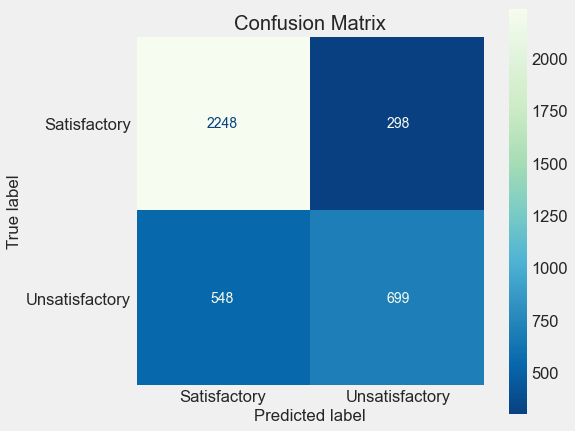

,Accuracy,F1,Recall,Precision
0,0.776958,0.622995,0.560545,0.701103


time: 1.07 s


In [91]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [92]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671208,0.000000,0.000000,0.000000,0.197439,Baseline DummyCFL
1,fsm,0.676480,0.260435,0.173748,0.522931,0.221505,FSM Naive Bayes
2,lsvc_ss,0.743891,0.529909,0.439188,0.667991,2.647121,Linear SVC SS()
3,logreg_ss,0.744946,0.539846,0.455226,0.663331,4.518865,LogReg SS()
4,svc_ss,0.758217,0.555314,0.459232,0.702513,25.132958,Support Vector CLF SS()
5,knn_ss,0.725346,0.531858,0.474734,0.604881,3.920994,KNN SS()
6,bclf_ss,0.756547,0.573671,0.498262,0.676321,15.084969,Bagging CLF SS()
7,rf_ss,0.766215,0.591752,0.515364,0.694747,12.656926,Random Forest SS()
11,vc_ss,0.773334,0.604494,0.526860,0.709063,26.234321,Voting CLF SS()
8,ada_ss,0.682105,0.523996,0.532480,0.516070,2.034409,AdaBoost SS()


time: 11.9 ms


## Neural Network

### Create Model

In [93]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=46, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.31 ms


In [94]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.36 ms


### Pipeline

In [95]:
nn_ss = make_pipeline(preprocessing_ss, NN)

time: 1.06 ms


### Fitting Models

In [96]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x18a1f8be0>)])

time: 6.46 s


In [97]:
# saving model
# path = os.path.join(gparent,'models/nn_ss.h5')
# nn_ss[2].model.save(path)

time: 758 µs


### Cross Val Scores

In [98]:
%%capture --no-display
# modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
#                 'Neural Net SS()')

time: 1.25 ms


### Test Data Confusion Matrix

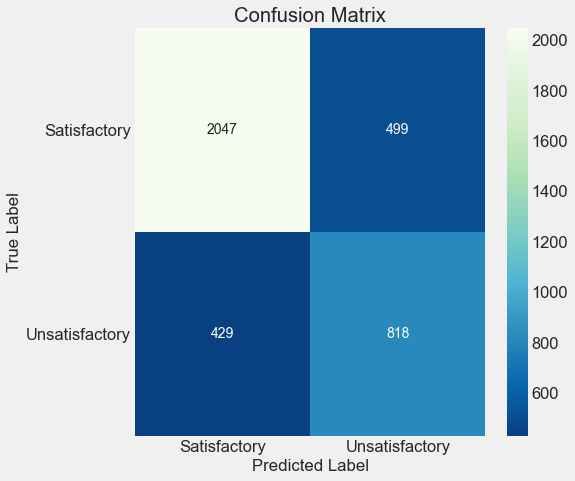

,Accuracy,F1,Recall,Precision
0,0.755339,0.638066,0.655974,0.621109


time: 767 ms


In [99]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary

In [100]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671208,0.000000,0.000000,0.000000,0.197439,Baseline DummyCFL
1,fsm,0.676480,0.260435,0.173748,0.522931,0.221505,FSM Naive Bayes
2,lsvc_ss,0.743891,0.529909,0.439188,0.667991,2.647121,Linear SVC SS()
3,logreg_ss,0.744946,0.539846,0.455226,0.663331,4.518865,LogReg SS()
4,svc_ss,0.758217,0.555314,0.459232,0.702513,25.132958,Support Vector CLF SS()
5,knn_ss,0.725346,0.531858,0.474734,0.604881,3.920994,KNN SS()
6,bclf_ss,0.756547,0.573671,0.498262,0.676321,15.084969,Bagging CLF SS()
7,rf_ss,0.766215,0.591752,0.515364,0.694747,12.656926,Random Forest SS()
11,vc_ss,0.773334,0.604494,0.526860,0.709063,26.234321,Voting CLF SS()
8,ada_ss,0.682105,0.523996,0.532480,0.516070,2.034409,AdaBoost SS()


time: 10.6 ms


## SMOTE

## Voting CLF SMOTE

In [101]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.06 ms


In [102]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.05 ms


### Fitting Model

In [103]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 11.2 s


In [104]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 763 µs


### Cross Val Scores

In [105]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

[0.7712246663705363,
 0.6331304228124305,
 0.6003723324503973,
 0.6699336492344586]

time: 45.2 s


### Test Data Confusion Matrix

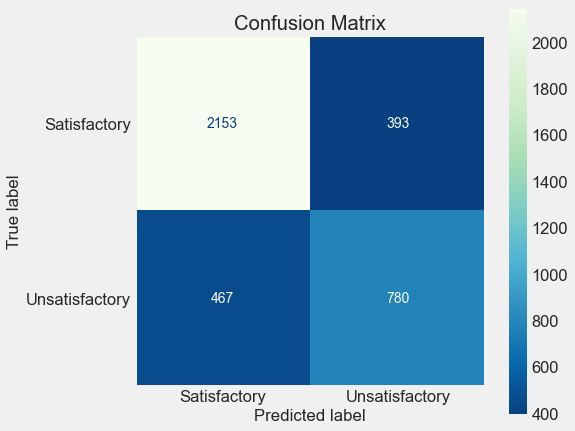

,Accuracy,F1,Recall,Precision
0,0.773267,0.644628,0.625501,0.664962


time: 1.13 s


In [106]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [107]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671208,0.000000,0.000000,0.000000,0.197439,Baseline DummyCFL
1,fsm,0.676480,0.260435,0.173748,0.522931,0.221505,FSM Naive Bayes
2,lsvc_ss,0.743891,0.529909,0.439188,0.667991,2.647121,Linear SVC SS()
3,logreg_ss,0.744946,0.539846,0.455226,0.663331,4.518865,LogReg SS()
4,svc_ss,0.758217,0.555314,0.459232,0.702513,25.132958,Support Vector CLF SS()
5,knn_ss,0.725346,0.531858,0.474734,0.604881,3.920994,KNN SS()
6,bclf_ss,0.756547,0.573671,0.498262,0.676321,15.084969,Bagging CLF SS()
7,rf_ss,0.766215,0.591752,0.515364,0.694747,12.656926,Random Forest SS()
8,vc_ss,0.773334,0.604494,0.526860,0.709063,26.234321,Voting CLF SS()
9,ada_ss,0.682105,0.523996,0.532480,0.516070,2.034409,AdaBoost SS()


time: 12.5 ms


vc_ss smote acc=0.773504 f1=0.639068 recall=0.609586 precision=0.671745 click_sum, num_activities

vc_ss smote acc=0.771 f1=0.635 recall=0.604 precision=0.669 click_sum+num_activities

## XGBoost SMOTE

In [114]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 1.06 ms


### Fitting Model

In [115]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8dfd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x110a8df70>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 2.71 s


In [116]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 803 µs


### Cross Val Scores

In [117]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

[0.7716638019274222, 0.632176322474983, 0.5968949686926598, 0.6721164931290737]

time: 9.86 s


### Test Data Confusion Matrix

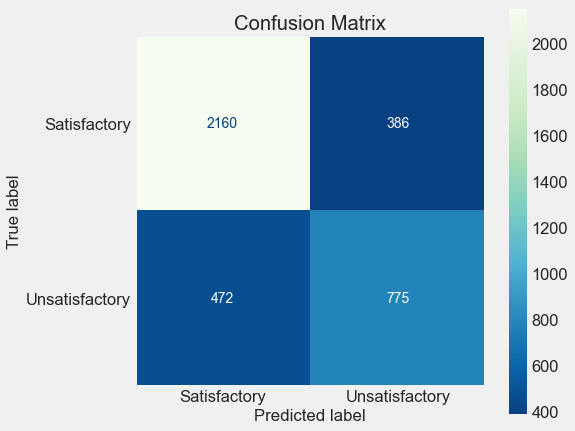

,Accuracy,F1,Recall,Precision
0,0.773794,0.643688,0.621492,0.667528


time: 468 ms


In [118]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Model Summary

In [119]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671208,0.000000,0.000000,0.000000,0.197439,Baseline DummyCFL
1,fsm,0.676480,0.260435,0.173748,0.522931,0.221505,FSM Naive Bayes
2,lsvc_ss,0.743891,0.529909,0.439188,0.667991,2.647121,Linear SVC SS()
3,logreg_ss,0.744946,0.539846,0.455226,0.663331,4.518865,LogReg SS()
4,svc_ss,0.758217,0.555314,0.459232,0.702513,25.132958,Support Vector CLF SS()
5,knn_ss,0.725346,0.531858,0.474734,0.604881,3.920994,KNN SS()
6,bclf_ss,0.756547,0.573671,0.498262,0.676321,15.084969,Bagging CLF SS()
7,rf_ss,0.766215,0.591752,0.515364,0.694747,12.656926,Random Forest SS()
8,vc_ss,0.773334,0.604494,0.526860,0.709063,26.234321,Voting CLF SS()
9,ada_ss,0.682105,0.523996,0.532480,0.516070,2.034409,AdaBoost SS()


time: 12.2 ms


## Neural Network SMOTE

### Pipeline

In [108]:
# nn_sm = make_sm_pipeline(preprocessing_ss, sm, NN)

time: 754 µs


### Fitting Models

In [109]:
# %%capture --no-display
# nn_sm.fit(X_train, y_train)

time: 728 µs


### Cross Val Scores

In [110]:
# %%capture --no-display
# modeling.report(nn_sm, X_train, y_train, 'nn_sm',\
#                 'Neural Net SS()/SMOTE')

time: 839 µs


### Test Data Confusion Matrix

In [111]:
# %%capture --no-display
# f.confusion_report_nn(nn_sm, X_test, y_test)

time: 853 µs


In [112]:
# saving model
# path = os.path.join(gparent,'models/nn_sm.h5')
# nn_sm[2].model.save(path)

time: 817 µs


## Model Summary

In [113]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.671208,0.000000,0.000000,0.000000,0.197439,Baseline DummyCFL
1,fsm,0.676480,0.260435,0.173748,0.522931,0.221505,FSM Naive Bayes
2,lsvc_ss,0.743891,0.529909,0.439188,0.667991,2.647121,Linear SVC SS()
3,logreg_ss,0.744946,0.539846,0.455226,0.663331,4.518865,LogReg SS()
4,svc_ss,0.758217,0.555314,0.459232,0.702513,25.132958,Support Vector CLF SS()
5,knn_ss,0.725346,0.531858,0.474734,0.604881,3.920994,KNN SS()
6,bclf_ss,0.756547,0.573671,0.498262,0.676321,15.084969,Bagging CLF SS()
7,rf_ss,0.766215,0.591752,0.515364,0.694747,12.656926,Random Forest SS()
8,vc_ss,0.773334,0.604494,0.526860,0.709063,26.234321,Voting CLF SS()
9,ada_ss,0.682105,0.523996,0.532480,0.516070,2.034409,AdaBoost SS()


time: 13.2 ms


In [120]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 26.7 ms
